<a href="https://colab.research.google.com/github/AK18k/ex2_1/blob/avis_lab/ex2_latenight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!git clone -b avis_lab https://github.com/AK18k/ex2_1



Cloning into 'ex2_1'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 129 (delta 6), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (129/129), 2.38 MiB | 11.64 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [11]:
import os
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/ex2_1/data/ptb'
PATH = '/content/ex2_1'
os.chdir('/content/ex2_1')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data	 ex2_1		      generate.py  model.py	README.md
data.py  ex2_latenight.ipynb  main.ipynb   __pycache__


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

device is cuda


# first model start

---


---



In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt

class Result_Matrix:
    def __init__(self, model_type):
      self.model_name = model_type
      self.nepochs = 0
      self.train_ppl = np.array([])
      self.val_ppl = np.array([])
      self.test_ppl = np.array([])

    def add_result(self, result, result_type = 'train'):
      if result_type == 'train':
        self.train_ppl = np.append(self.train_ppl, result)
      elif result_type == 'val':
        self.val_ppl = np.append(self.val_ppl, result)
      elif result_type == 'test':
        self.test_ppl = np.append(self.test_ppl, result)

    def get_results(self, result_type = 'train'):
      if result_type == 'train':
        return(self.train_ppl)
      elif result_type == 'val':
        return(self.val_ppl)
      elif result_type == 'test':
        return(self.test_ppl) 


def plot_results(result_matrix, file_name):
  plt.figure()
  y = result_matrix.get_results('train')
  plt.plot(np.arange(1,len(y)+1), y, label = 'train', color = 'blue')
  y = result_matrix.get_results('val')
  plt.plot(np.arange(1,len(y)+1), y, label = 'val', color = 'green')
  y = result_matrix.get_results('test')
  plt.plot(np.arange(1,len(y)+1), y, label = 'test', color = 'red')
  plt.legend()
  plt.title(f'Model Type = {result_matrix.model_name}')
  #plt.ylim((0.75, 1))
  plt.xlabel('eoch')
  plt.ylabel('perplexity')
  plt.grid()
  plt.show() 

  plt.savefig(file_name) 


In [21]:
# coding: utf-8
import argparse
import time
import math
import os
import torch
import torch.nn as nn
import torch.onnx

import data
import model

parser = argparse.ArgumentParser(description='PyTorch Wikitext-2 RNN/LSTM/GRU/Transformer Language Model')
parser.add_argument('--data', type=str, default='./data/ptb',
                    help='location of the data corpus')
parser.add_argument('--model', type=str, default='LSTM',
                    help='type of network (RNN_TANH, RNN_RELU, LSTM, GRU, Transformer)')
parser.add_argument('--emsize', type=int, default=200,
                    help='size of word embeddings')
parser.add_argument('--nhid', type=int, default=200,
                    help='number of hidden units per layer')
parser.add_argument('--nlayers', type=int, default=2,
                    help='number of layers')
parser.add_argument('--lr', type=float, default=20,
                    help='initial learning rate')
parser.add_argument('--clip', type=float, default=0.25,
                    help='gradient clipping')
parser.add_argument('--epochs', type=int, default=40,
                    help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=20, metavar='N',
                    help='batch size')
parser.add_argument('--bptt', type=int, default=35,
                    help='sequence length')
parser.add_argument('--dropout', type=float, default=0.2,
                    help='dropout applied to layers (0 = no dropout)')
parser.add_argument('--tied', action='store_true',
                    help='tie the word embedding and softmax weights')
parser.add_argument('--seed', type=int, default=1111,
                    help='random seed')
parser.add_argument('--cuda', action='store_true', default=True,
                    help='use CUDA')
parser.add_argument('--mps', action='store_true', default=False,
                        help='enables macOS GPU training')
parser.add_argument('--log-interval', type=int, default=200, metavar='N',
                    help='report interval')
parser.add_argument('--save', type=str, default='model.pt',
                    help='path to save the final model')
parser.add_argument('--onnx-export', type=str, default='',
                    help='path to export the final model in onnx format')
parser.add_argument('--nhead', type=int, default=2,
                    help='the number of heads in the encoder/decoder of the transformer model')
parser.add_argument('--dry-run', action='store_true',
                    help='verify the code and the model')
# args = parser.parse_args()
args, unknown = parser.parse_known_args()

# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda.")
if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    if not args.mps:
        print("WARNING: You have mps device, to enable macOS GPU run with --mps.")

use_mps = args.mps and torch.backends.mps.is_available()
if args.cuda:
    device = torch.device("cuda")
    print('CUDA is active')
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

###############################################################################
# Load data
###############################################################################

corpus = data.Corpus(args.data)

# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.

def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

eval_batch_size = 10
train_data = batchify(corpus.train, args.batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

###############################################################################
# Build the model
###############################################################################

ntokens = len(corpus.dictionary)
if args.model == 'Transformer':
    model = model.TransformerModel(ntokens, args.emsize, args.nhead, args.nhid, args.nlayers, args.dropout).to(device)
else:
    model = model.RNNModel(args.model, ntokens, args.emsize, args.nhid, args.nlayers, args.dropout, args.tied).to(device)

criterion = nn.NLLLoss()

###############################################################################
# Training code
###############################################################################

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""

    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


# get_batch subdivides the source data into chunks of length args.bptt.
# If source is equal to the example output of the batchify function, with
# a bptt-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. The chunks are along dimension 0, corresponding
# to the seq_len dimension in the LSTM.

def get_batch(source, i):
    seq_len = min(args.bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target


def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    if args.model != 'Transformer':
        hidden = model.init_hidden(eval_batch_size)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, args.bptt):
            data, targets = get_batch(data_source, i)
            if args.model == 'Transformer':
                output = model(data)
                output = output.view(-1, ntokens)
            else:
                output, hidden = model(data, hidden)
                hidden = repackage_hidden(hidden)
            total_loss += len(data) * criterion(output, targets).item()
    return total_loss / (len(data_source) - 1)


def train():
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    if args.model != 'Transformer':
        hidden = model.init_hidden(args.batch_size)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, args.bptt)):
        data, targets = get_batch(train_data, i)
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        model.zero_grad()
        if args.model == 'Transformer':
            output = model(data)
            output = output.view(-1, ntokens)
        else:
            hidden = repackage_hidden(hidden)
            output, hidden = model(data, hidden)
        loss = criterion(output, targets)
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        for p in model.parameters():
            p.data.add_(p.grad, alpha=-lr)

        total_loss += loss.item()

        if batch % args.log_interval == 0 and batch > 0:
            cur_loss = total_loss / args.log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // args.bptt, lr,
                elapsed * 1000 / args.log_interval, cur_loss, math.exp(cur_loss)))
            
            results_m.add_result(math.exp(cur_loss), 'train') #add train ppl to result matrix

            total_loss = 0
            start_time = time.time()
        if args.dry_run:
            break


def export_onnx(path, batch_size, seq_len):
    print('The model is also exported in ONNX format at {}.'.format(os.path.realpath(args.onnx_export)))
    model.eval()
    dummy_input = torch.LongTensor(seq_len * batch_size).zero_().view(-1, batch_size).to(device)
    hidden = model.init_hidden(batch_size)
    torch.onnx.export(model, (dummy_input, hidden), path)


# Loop over epochs.
lr = args.lr
best_val_loss = None

# At any point you can hit Ctrl + C to break out of training early.
try:
    results_m = Result_Matrix(args.model) #create a result matrix for the model
  
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(val_data)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        
        results_m.add_result(math.exp(val_loss), 'val') #add val ppl to result matrix

        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(args.save, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 4.0
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)
    # after load the rnn params are not a continuous chunk of memory
    # this makes them a continuous chunk, and will speed up forward pass
    # Currently, only rnn model supports flatten_parameters function.
    if args.model in ['RNN_TANH', 'RNN_RELU', 'LSTM', 'GRU']:
        model.rnn.flatten_parameters()

# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

results_m.add_result(math.exp(test_loss), 'test') #add test ppl to result matrix

plot_results(results_m)

if len(args.onnx_export) > 0:
    # Export the model in ONNX format.
    export_onnx(args.onnx_export, batch_size=1, seq_len=args.bptt)

CUDA is active
| epoch   1 |   200/ 1327 batches | lr 20.00 | ms/batch 11.27 | loss  6.92 | ppl  1016.42
| epoch   1 |   400/ 1327 batches | lr 20.00 | ms/batch  6.11 | loss  6.30 | ppl   545.22
| epoch   1 |   600/ 1327 batches | lr 20.00 | ms/batch  6.13 | loss  6.05 | ppl   423.20
| epoch   1 |   800/ 1327 batches | lr 20.00 | ms/batch  6.26 | loss  5.77 | ppl   321.89
| epoch   1 |  1000/ 1327 batches | lr 20.00 | ms/batch  6.48 | loss  5.63 | ppl   278.37
| epoch   1 |  1200/ 1327 batches | lr 20.00 | ms/batch  6.50 | loss  5.47 | ppl   237.81
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  9.70s | valid loss  5.38 | valid ppl   217.69
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1327 batches | lr 20.00 | ms/batch  6.15 | loss  5.38 | ppl   217.06
| epoch   2 |   400/ 1327 batches | lr 20.00 | ms/batch  6.16 | loss  5.32 | ppl   204.08
| epoch   2

TypeError: ignored

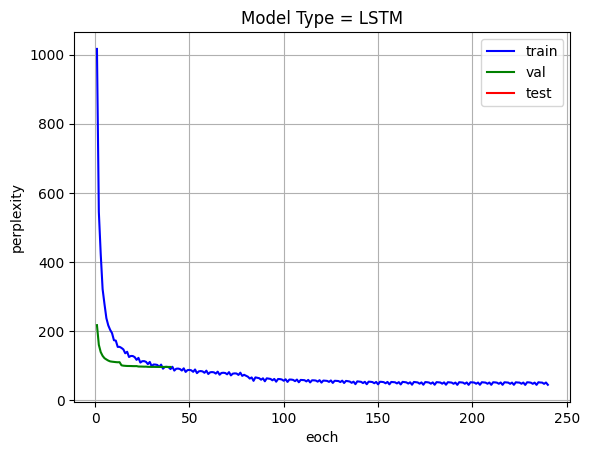

<Figure size 640x480 with 0 Axes>

In [22]:
plot_results(results_m, 'first')

# other model start

---



---



In [ ]:
import os
import torch

from collections import Counter


class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        self.counter = Counter()
        self.total = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        token_id = self.word2idx[word]
        self.counter[token_id] += 1
        self.total += 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx[word]
                    token += 1

        return ids


In [ ]:
# Get first 100 words

for word_index in range(100):
  print(f'word index = {word_index}, word = {corpus.dictionary.idx2word[word_index]}')

In [ ]:
# Assume `data` is a 1D tensor containing your entire dataset
batch_size = 20
seq_length = 35
data = corpus.train
num_batches = data.size(0) // (batch_size * seq_length)

# Discard any extra data that won't fit into full batches
data = data[:num_batches * batch_size * seq_length]

# Reshape data into [batch_size, -1], maintaining continuity across batches
data = data.view(batch_size, -1)

print(data[:, 0:35])
print()

In [ ]:
# Evaluate the model on test data

def test_model(model_):
  model_.eval()  

  # Define a variable to hold the total loss of the model on the test data
  total_loss = 0
  total_samples_count = 0

  with torch.no_grad():  # turn off gradients, since we are in test mode
      for inputs in test_dataloader:
          inputs = inputs.to(device)

          targets = inputs[:, 1:].contiguous()
          inputs = inputs[:, :-1].contiguous()

          # Forward pass
          outputs = model(inputs)
          outputs = outputs.view(-1, outputs.size(-1))

          targets = targets.view(-1)
          targets = targets.to(device)

          loss = loss_function(outputs, targets)

          #total_loss += loss.item()

          batch_size = inputs.size(0)
          total_loss += loss.item() * batch_size
          total_samples_count += batch_size 

  # Compute the average loss over the entire test data
  #average_loss = total_loss / len(test_dataloader)

  # Compute perplexity based on the average loss
  #test_perplexity = math.exp(average_loss)
  test_perplexity = np.exp(total_loss / total_samples_count)

  results_m.add_result(test_perplexity, 'test') 

  #print(f"Test result, Average Loss: {average_loss}, Test Perplexity: {test_perplexity}")
  print(f"Test results  - Loss: {loss.item()}, Perplexity: {test_perplexity.item()}")
  print('-------------------------------------------------------------------------')


In [ ]:
corpus = Corpus('data/ptb')

In [ ]:
# hyper params
model_type = "LSTM" #change to GRU 
total_epochs = 15
embedding_dim = 1500
hidden_dim = 200
drop_out = 0.4
learning_rate = 1e-2
# hyper params

# Set the random seed manually for reproducibility.
torch.manual_seed(1111)

# First, let's define a custom Dataset to read the vectors of words
class PTBDataset(Dataset):
    def __init__(self, data_, sequence_length_=35):
        # In practice, `data` should be a list of integers representing the words in the PTB data set.
        # self.data = [torch.tensor(item, dtype=torch.long) for item in data]
        self.data = data_
        self.sequence_length = sequence_length_ + 1
  
    def __len__(self):
        return len(self.data) // self.sequence_length
   
    def __getitem__(self, idx):
        x = self.data[idx * self.sequence_length: (idx + 1) * self.sequence_length]
        return x

# Collate function to pad sequences in the same batch to the same length
def collate(batch):
    return pad_sequence(batch, batch_first=True)

# Create a DataLoader
train_data = corpus.train  
data = train_data
print(data)
dataset = PTBDataset(data)
# dataloader = DataLoader(dataset, batch_size=20, collate_fn=collate, shuffle=True)
dataloader = DataLoader(dataset, batch_size=20, collate_fn=collate, shuffle=False)

# Prepare test data
test_data = corpus.test
test_dataset = PTBDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=collate, shuffle=False)

# Now let's define the LSTM language model
class LanguageModel(nn.Module):
    def __init__(self, model_type_, vocab_size, embedding_dim, hidden_dim, nlayers = 2, dropout_ = 0):
        super(LanguageModel, self).__init__()
        self.model_type = model_type_
        self.hidden_dim = hidden_dim
        self.nlayers = nlayers        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = dropout_
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers = nlayers, dropout = dropout_)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, num_layers = nlayers, dropout = dropout_)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.hidden = self.init_hidden(20)  

    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        if self.model_type == 'LSTM':
            return (weight.new_zeros(self.nlayers, batch_size, self.hidden_dim),
                    weight.new_zeros(self.nlayers, batch_size, self.hidden_dim))
        else:  # GRU
            return weight.new_zeros(self.nlayers, batch_size, self.hidden_dim)        

    def repackage_hidden(self, h):
        """Wraps hidden states in new Tensors, to detach them from their history."""
        if isinstance(h, torch.Tensor):
            return h.detach()
        else:
            return tuple(self.repackage_hidden(v) for v in h)

    def forward(self, x):
        self.hidden = self.repackage_hidden(self.hidden)

        x = self.embeddings(x)
        if model_type == 'LSTM':
          x, _ = self.lstm(x)
        elif model_type == 'GRU':
          x, _ = self.gru(x)  
        x = self.linear(x)

        return x

# Create the model
vocab_size = len(corpus.dictionary)  

model = LanguageModel(model_type, vocab_size, embedding_dim, hidden_dim, dropout_ = drop_out)

model = model.to(device)

# Define a loss function
loss_function = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
results_m = Result_Matrix(f'{model.model_type}. Dropout = {model.dropout != 0}') 

for epoch in range(total_epochs):  
    model.train()
    total_loss = 0.0
    total_samples_count = 0
    for inputs in dataloader:
        inputs = inputs.to(device)        

        targets = inputs[:, 1:].contiguous()
        inputs = inputs[:, :-1].contiguous()

        if (10 < epoch):
          #print(f'inputs = {inputs[3, :]}')
          words_index = inputs[0, :].cpu()
          print('model input', end = ' ')
          for word_index in words_index:
            print(corpus.dictionary.idx2word[word_index], end = ' ')

          print('\n')

          print('model target:', end = ' ')
          words_index = targets[0, :].cpu()
          for word_index in words_index:
            print(corpus.dictionary.idx2word[word_index], end = ' ')
          print('\n')

        # Forward pass
        print(inputs.shape)
        keysin = input('press any key')
        outputs = model(inputs)


        if (10 < epoch):
          # Get class indices
          _, predicted_indices = torch.max(outputs[0, :, :], -1)

          # Convert indices to words
          predicted_words = [corpus.dictionary.idx2word[index] for index in predicted_indices]

          # Print predicted words
          print('model output:', end = '')
          for word in predicted_words:
              print(word, end=' ')
          print('\n')        

          #user_inp = input('press any key')


        outputs = outputs.view(-1, outputs.size(-1))

        targets = targets.to(device).view(-1)
       
        loss = loss_function(outputs, targets)

        batch_size = inputs.size(0)
        total_loss += loss.item() * batch_size
        total_samples_count += batch_size        
              
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        # Print gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
              if torch.any(1e3 < torch.abs(param.grad)):
                print(f"Gradient of {name} is {param.grad.data}")        

        optimizer.step()
   
    # Calculate perplexity
    perplexity = np.exp(total_loss / total_samples_count)
    results_m.add_result(perplexity, 'train')  

    print(f"Epoch: {epoch + 1}")
    print(f"Train results - Loss: {loss.item()}, Perplexity: {perplexity.item()}")

    test_model(model)

plot_results(results_m, f'{model.model_type} Dropout = {model.dropout != 0}.jpg')

In [ ]:
outputs.shape

york ruling that all manufacturers of an <unk> drug are liable for injuries or deaths if the actual maker is n't known <eos> revco received a $ N million takeover offer from texas financier robert 



york ruling that all manufacturers of an <unk> drug are liable for injuries or deaths if the actual maker is n't known 
 revco received a $ N million takeover offer from texas financier robert bass and acadia partners

In [ ]:
output_softmax = F.softmax(outputs[5])


y = output_softmax.cpu()
y = y.detach().numpy()
print(np.sum(y))
print(y.shape)
plt.plot(np.arange(1,len(y)+1), y, label = 'outputs', color = 'blue')


#plt.legend()
plt.title(f'outputs at epoch = {epoch}')
#plt.ylim((0.75, 1))
plt.xlabel('output')
plt.ylabel('value')
plt.grid()
plt.show()

In [ ]:
plot_results(results_m, f'{model.model_type} Dropout = {model.dropout != 0}.jpg')

In [ ]:
x1 = torch.randn(3, 5, requires_grad=True)
print(x1)
